In [22]:
import json
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from wordcloud import WordCloud
from collections import Counter
import re
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add palatino-clone fonts to matplotlib
import matplotlib.font_manager as fm
for font_file in os.listdir('fonts'):
    if font_file.endswith('.otf'):
        fm.fontManager.addfont(os.path.join('fonts', font_file))
# Configure matplotlib
plt.rcParams['font.family'] = 'TeX Gyre Pagella'
plt.rcParams['mathtext.fontset'] = 'stix'

class PromptAnalyzer:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', load = True):
        """
        Initialize the prompt analyzer with a sentence transformer model.
        
        Args:
            model_name: HuggingFace sentence transformer model name
        """
        
        if load:
            print(f"Loading sentence transformer model: {model_name}")
            self.model = SentenceTransformer(model_name)
        self.embeddings = None
        self.cluster_labels = None
        self.prompts_df = None
        
    def load_and_prepare_data(self, datasets: Dict[str, List[str]]) -> pd.DataFrame:
        """
        Load prompts from multiple datasets and prepare for analysis.
        
        Args:
            datasets: Dictionary with dataset_name -> list of prompts
            
        Returns:
            DataFrame with prompts and dataset labels
        """
        all_data = []
        for dataset_name, prompts in datasets.items():
            for prompt in prompts:
                all_data.append({
                    'prompt': prompt,
                    'dataset': dataset_name,
                    'length': len(prompt.split())
                })
        
        self.prompts_df = pd.DataFrame(all_data)
        print(f"Loaded {len(self.prompts_df)} prompts from {len(datasets)} datasets")
        return self.prompts_df
    
    def generate_embeddings(self, prompts: List[str]) -> np.ndarray:
        """
        Generate sentence embeddings for the prompts.
        
        Args:
            prompts: List of prompt strings
            
        Returns:
            Numpy array of embeddings
        """
        print(f"Generating embeddings for {len(prompts)} prompts...")
        embeddings = self.model.encode(prompts, show_progress_bar=True)
        self.embeddings = embeddings
        return embeddings
    
    def cluster_prompts(self, n_clusters: int = 10, method: str = 'kmeans') -> np.ndarray:
        """
        Cluster the embedded prompts.
        
        Args:
            n_clusters: Number of clusters
            method: Clustering method ('kmeans' supported for now)
            
        Returns:
            Array of cluster labels
        """
        if self.embeddings is None:
            raise ValueError("Generate embeddings first using generate_embeddings()")
        
        print(f"Clustering prompts into {n_clusters} clusters using {method}...")
        
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            labels = clusterer.fit_predict(self.embeddings)
        else:
            raise ValueError(f"Clustering method '{method}' not supported")
        
        self.cluster_labels = labels
        if self.prompts_df is not None:
            self.prompts_df['cluster'] = labels
            
        return labels
    
    def reduce_dimensions(self, method: str = 'umap', n_components: int = 2, **kwargs) -> np.ndarray:
        """
        Reduce dimensionality for visualization.
        
        Args:
            method: 'umap', 'tsne', or 'pca'
            n_components: Number of output dimensions
            **kwargs: Additional parameters for the reduction method
            
        Returns:
            Reduced dimension coordinates
        """
        if self.embeddings is None:
            raise ValueError("Generate embeddings first using generate_embeddings()")
        
        print(f"Reducing dimensions using {method}...")
        
        if method == 'umap':
            reducer = umap.UMAP(
                n_components=n_components,
                random_state=42,
                n_neighbors=kwargs.get('n_neighbors', 15),
                min_dist=kwargs.get('min_dist', 0.1)
            )
        elif method == 'tsne':
            reducer = TSNE(
                n_components=n_components,
                random_state=42,
                perplexity=kwargs.get('perplexity', 30)
            )
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=42)
        else:
            raise ValueError(f"Reduction method '{method}' not supported")
        
        coords = reducer.fit_transform(self.embeddings)
        return coords
    
    
    
    def visualize_clusters(self, coords: np.ndarray, color_by: str = 'cluster', 
                          figsize: Tuple[int, int] = (8, 8), save_path: Optional[str] = None,
                          xlim: Optional[Tuple[float, float]] = None,
                          ylim: Optional[Tuple[float, float]] = None,
                          show_cluster_id: bool = True,
                          plot_legend: bool = True,
                          top_n: Optional[int] = 3) -> None:
        """
        Visualize the clustered prompts in 2D space.
        
        Args:
            coords: 2D coordinates from dimensionality reduction
            color_by: 'cluster' or 'dataset'
            figsize: Figure size
            save_path: Path to save the plot
        """
        if self.prompts_df is None:
            raise ValueError("Load data first using load_and_prepare_data()")
        
        plt.figure(figsize=figsize)
        fs = 16
        fs_legend = 11.1
        if color_by == 'cluster' and self.cluster_labels is not None:
            # Get unique clusters and their sizes
            unique_clusters = np.unique(self.cluster_labels)
            cluster_counts = np.bincount(self.cluster_labels)
            colors = get_distinct_colors(len(unique_clusters))

            # Sort clusters by size (descending)
            cluster_sizes = [(cluster_id, cluster_counts[cluster_id]) for cluster_id in unique_clusters]
            cluster_sizes.sort(key=lambda x: x[1], reverse=True)

            # Create scatter plot for each cluster with custom legend (ordered by size)
            legend_handles = []
            for i, (cluster_id, cluster_size) in enumerate(cluster_sizes):
                mask = self.cluster_labels == cluster_id
                cluster_size = cluster_counts[cluster_id]
                top_words_list_clusters = create_cluster_wordcloud(analyzer=self, cluster_id=cluster_id, n_top_words=top_n, show=False)
                if show_cluster_id:
                    label = f'{cluster_id:02}:\t{", ".join(top_words_list_clusters)} (n={cluster_size})'
                else:
                    label = f'{", ".join(top_words_list_clusters)} (n={cluster_size})'
                
                scatter = plt.scatter(coords[mask, 0], coords[mask, 1], 
                          c=[colors[i]], label=label, alpha=0.1, s=30)
                
                # Create a legend handle with larger marker size
                legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label))
            
            if plot_legend:
                # Add custom legend with larger markers
                plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, frameon=False, fontsize=fs_legend)
            
        elif color_by == 'dataset':
            datasets = self.prompts_df['dataset'].unique()
            colors = ["#092B8C","#00B4D8","#6CD874"]
            
            legend_handles = []
            for i, dataset in enumerate(datasets):
                mask = self.prompts_df['dataset'] == dataset
                dataset_size = mask.sum()
                label = f'{dataset} (n={dataset_size})'
                
                scatter = plt.scatter(coords[mask, 0], coords[mask, 1], 
                          c=[colors[i]], label=label, alpha=0.1, s=30)
                
                # Create a legend handle with larger marker size
                legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label))
            
            if plot_legend:
                # Add custom legend with larger markers
                plt.legend(handles=legend_handles, loc='lower right', frameon=False, ncol=1, fontsize=fs_legend)

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

        # Turn top and right spines off
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Show 5 each x and y ticks on axes, but no tick labels
        plt.xticks(ticks=np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 5), labels=[])
        plt.yticks(ticks=np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), 5), labels=[])
        
        plt.xlabel('t-SNE Dimension 1', fontsize=fs)
        plt.ylabel('t-SNE Dimension 2', fontsize=fs)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.show()

def create_wordcloud(texts: List[str], title: str = "", 
                    figsize: Tuple[int, int] = (10, 5),
                    max_words: int = 100, 
                    background_color: str = 'white',
                    colormap: str = 'viridis',
                    save_path: Optional[str] = None,
                    n_top_words: int = 10,
                    show: bool = True
                    ) -> WordCloud:
    """
    Create a word cloud from a list of texts.
    
    Args:
        texts: List of text strings
        title: Title for the plot
        figsize: Figure size
        max_words: Maximum number of words in the cloud
        background_color: Background color
        colormap: Color scheme
        save_path: Path to save the plot
        
    Returns:
        WordCloud object
    """
    # Combine all texts
    combined_text = ' '.join(texts)
    
    # Clean and preprocess text
    # Remove common stopwords that might not be meaningful for prompts
    stopwords = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
                'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
                'to', 'was', 'were', 'will', 'with', 'the', 'this', 'but', 'they',
                'have', 'had', 'what', 'said', 'each', 'which', 'she', 'do',
                'how', 'their', 'if', 'up', 'out', 'many', 'then', 'them', 'these',
                'so', 'some', 'her', 'would', 'make', 'like', 'into', 'him', 'time',
                'two', 'more', 'very', 'after', 'words', 'long', 'than', 'first',
                'been', 'call', 'who', 'sit', 'now', 'find', 'down', 'way',
                'may', 'get', 'use', 'new', 'our', 'me',}
    
    # Create word cloud
    wordcloud = WordCloud(
        width=figsize[0]*100, 
        height=figsize[1]*100,
        max_words=max_words,
        background_color=background_color,
        colormap=colormap,
        stopwords=stopwords,
        collocations=False,  # Avoid pairing words
        relative_scaling=0.5
    ).generate(combined_text)

    if show:
        # Plot
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        if title:
            plt.title(title, fontsize=16, pad=20)
        plt.tight_layout()

    word_freqs = {word: freq for word, freq in wordcloud.words_.items()}
    sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_words[:n_top_words]
    top_words_list = [word for word, _ in top_words]

    if show:
        print(f"\nTop {n_top_words} words in {title}: {', '.join(top_words_list)}")
        
    
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    return top_words_list

def create_dataset_wordclouds(datasets: Dict[str, List[str]], 
                            figsize: Tuple[int, int] = (15, 5),
                            save_path: Optional[str] = None,
                            n_top_words: int = 10,
                            show = True, 
                            colormap: str = 'viridis',) -> None:
    """
    Create word clouds for each dataset.
    
    Args:
        datasets: Dictionary with dataset_name -> list of prompts
        figsize: Figure size for each subplot
        save_dir: Directory to save individual plots
    """
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(figsize[0], figsize[1]))
    
    if n_datasets == 1:
        axes = [axes]
    
    for i, (name, prompts) in enumerate(datasets.items()):
        combined_text = ' '.join(prompts)
        
        # Remove common stopwords that might not be meaningful for prompts
        stopwords = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
                    'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
                    'to', 'was', 'were', 'will', 'with', 'the', 'this', 'but', 'they',
                    'have', 'had', 'what', 'said', 'each', 'which', 'she', 'do',
                    'how', 'their', 'if', 'up', 'out', 'many', 'then', 'them', 'these',
                    'so', 'some', 'her', 'would', 'make', 'like', 'into', 'him', 'time',
                    'two', 'more', 'very', 'after', 'words', 'long', 'than', 'first',
                    'been', 'call', 'who', 'sit', 'now', 'find', 'down', 'way',
                    'may', 'get', 'use', 'new', 'our', 'me',}
        
        wordcloud = WordCloud(
            width=1200, height=800,
            max_words=100,
            background_color=None,
            colormap=colormap,
            stopwords=stopwords,
            collocations=False,
            max_font_size=200,
            mode='RGBA',
        ).generate(combined_text)
        
        if show:
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].text(0.5, -0.05, f'{name} (n = {len(prompts)})', fontsize=16, fontweight='bold', ha='center', va='top', transform=axes[i].transAxes)
        
            # Extract word frequencies and sort by count
        word_freqs = {word: freq for word, freq in wordcloud.words_.items()}
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
        top_words = sorted_words[:n_top_words]
        top_words_list = [word for word, _ in top_words]
        print(f"\nTop {n_top_words} words in {name}: {', '.join(top_words_list)}")
        if save_path:
            save_dir = os.path.join(save_path, name)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            wordcloud.to_file(os.path.join(save_dir, f'{name}_wordcloud.png'))
            svg_file = wordcloud.to_svg(embed_font=True)
            with open(os.path.join(save_dir, f'{name}_wordcloud.svg'), 'w') as f:
                f.write(svg_file)
        
    if show:
        plt.tight_layout()
        if save_path:
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
        
                wordcloud.to_svg(save_path)
        plt.show()

    return top_words_list

def create_cluster_wordcloud(analyzer: PromptAnalyzer, cluster_id: int,
                           title: Optional[str] = None,
                           figsize: Tuple[int, int] = (10, 5),
                           save_path: Optional[str] = None,
                            n_top_words: int = 10,
                           show = True) -> WordCloud:
    """
    Create a word cloud for a specific cluster.
    
    Args:
        analyzer: PromptAnalyzer instance with clustered data
        cluster_id: ID of the cluster to visualize
        title: Custom title (auto-generated if None)
        figsize: Figure size
        save_path: Path to save the plot
        
    Returns:
        WordCloud object
    """
    if analyzer.prompts_df is None or 'cluster' not in analyzer.prompts_df.columns:
        raise ValueError("Analyzer must have clustered data")
    
    # Get prompts from the specified cluster
    cluster_prompts = analyzer.prompts_df[
        analyzer.prompts_df['cluster'] == cluster_id
    ]['prompt'].tolist()
    
    if not cluster_prompts:
        raise ValueError(f"No prompts found in cluster {cluster_id}")
    
    if title is None:
        title = f"Cluster {cluster_id} ({len(cluster_prompts)} prompts)"
    
    return create_wordcloud(cluster_prompts, title=title, figsize=figsize, 
                          save_path=save_path, n_top_words=n_top_words, show=show)

def analyze_cluster_composition(analyzer: PromptAnalyzer) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze the dataset composition of each cluster, ordered from largest to smallest cluster.
    
    Args:
        analyzer: PromptAnalyzer instance with clustered data
        
    Returns:
        Tuple of DataFrames with cluster composition statistics: (counts, percentages)
    """
    if analyzer.prompts_df is None or 'cluster' not in analyzer.prompts_df.columns:
        raise ValueError("Analyzer must have clustered data")
    
    # Get cluster sizes
    cluster_sizes = analyzer.prompts_df['cluster'].value_counts()
    
    # Create composition table
    composition = analyzer.prompts_df.groupby(['cluster', 'dataset']).size().unstack(fill_value=0)
    
    # Reindex composition by cluster size (descending)
    composition = composition.reindex(cluster_sizes.index)
    
    # Calculate percentages
    composition_pct = composition.div(composition.sum(axis=1), axis=0) * 100
    
    # Add cluster sizes as a column for reference
    composition['total'] = cluster_sizes
    
    print("Cluster Composition (counts):")
    print(composition)
    print("\nCluster Composition (percentages):")
    print(composition_pct.round(1))
    
    return composition, composition_pct

def mean_prompt_length_per_dataset(analyzer: PromptAnalyzer) -> pd.DataFrame:
    """
    Calculate mean prompt length for each dataset.
    
    Args:
        analyzer: PromptAnalyzer instance with loaded data
        
    Returns:
        DataFrame with mean prompt lengths
    """
    if analyzer.prompts_df is None:
        raise ValueError("Load data first using load_and_prepare_data()")
    
    mean_lengths = analyzer.prompts_df.groupby('dataset')['length'].mean().reset_index()
    mean_lengths.columns = ['dataset', 'mean_length']
    
    


    
    print("Mean Prompt Lengths by Dataset:")
    print(mean_lengths)
    
    return mean_lengths

def mean_prompt_length_per_cluster(analyzer: PromptAnalyzer) -> pd.DataFrame:
    """
    Calculate mean prompt length for each cluster.
    
    Args:
        analyzer: PromptAnalyzer instance with clustered data
        
    Returns:
        DataFrame with mean prompt lengths per cluster
    """
    if analyzer.prompts_df is None or 'cluster' not in analyzer.prompts_df.columns:
        raise ValueError("Analyzer must have clustered data")
    
    mean_lengths = analyzer.prompts_df.groupby('cluster')['length'].mean().reset_index()
    mean_lengths.columns = ['cluster', 'mean_length']

    cluster_sizes = analyzer.prompts_df['cluster'].value_counts()
    # sort mean_lengths by cluster size
    mean_lengths = mean_lengths.set_index('cluster').reindex(cluster_sizes.index).reset_index()
    
    print("Mean Prompt Lengths by Cluster:")
    print(mean_lengths)
    
    return mean_lengths

def get_distinct_colors(n_colors):
        """
        Generate a list of distinct colors, prioritizing the most distinguishable ones first.
        
        Args:
            n_colors: Number of colors to generate
            
        Returns:
            List of RGBA colors
        """
        # Start with the most distinct colormaps
        distinct_colormaps = ['tab10', 'Set1', 'Dark2', 'Set2', 'tab20b', 'tab20c', 'Accent']
        
        # Initialize an empty list to store colors
        colors = []
        
        # Add colors from each colormap
        for cmap_name in distinct_colormaps:
            cmap = plt.cm.get_cmap(cmap_name)
            # Get the number of colors in this colormap
            if cmap_name.startswith('tab20') or cmap_name == 'Set3':
                n_colors_in_cmap = 20
            elif cmap_name.startswith('tab10') or cmap_name in ['Set1', 'Set2', 'Dark2', 'Paired', 'Accent']:
                n_colors_in_cmap = 10 if cmap_name != 'Accent' else 8
            else:
                n_colors_in_cmap = 8
            
            # Add colors from this colormap
            for i in range(n_colors_in_cmap):
                color = cmap(i / n_colors_in_cmap)
                # Check if this color is similar to any already added color
                if not any(np.allclose(color[:3], c[:3], atol=0.1) for c in colors):
                    colors.append(color)
                    if len(colors) >= n_colors:
                        return colors
        
        # If we still need more colors, add interpolated colors from the HSV colorspace
        if len(colors) < n_colors:
            hsv_colors = plt.cm.hsv(np.linspace(0, 1, n_colors - len(colors)))
            for color in hsv_colors:
                if not any(np.allclose(color[:3], c[:3], atol=0.1) for c in colors):
                    colors.append(color)
                    if len(colors) >= n_colors:
                        return colors
        
        # If we still don't have enough, use a continuous colormap
        if len(colors) < n_colors:
            remaining = n_colors - len(colors)
            colors.extend(plt.cm.viridis(np.linspace(0, 1, remaining)))
        
        return colors[:n_colors]

# Calculation

In [33]:
# Example datasets (replace with your actual data loading)
n_samples = 5000  # Limit to 2000 samples for performance

# with open('coco/captions_val2017.json') as f:
#         coco_ds = [ann['caption'] for ann in json.load(f)['annotations']]
#         random.shuffle(coco_ds)  # Shuffle for randomness
#         coco_ds = coco_ds[:n_samples]  # Limit to 1000 samples for performance

#sdprompts_ds = [sample['Prompt'] for sample in load_dataset('Gustavosta/Stable-Diffusion-Prompts')['train']]#[:n_samples]  # Limit to 2000 samples for performance

mjprompts_ds = [prompt for i in range(1, 30) for prompt in [sample['caption'] for sample in load_dataset('bghira/mj-v52-redux')[f'Collection_{i}']]]#[:n_samples]  # Limit to 2000 samples for performance


datasets = {
    #'COCO': coco_ds,
    #'Stable Diffusion Prompts': sdprompts_ds,
    'Midjourney Prompts': mjprompts_ds
}

# # Initialize analyzer
analyzer = PromptAnalyzer()

# # Load and prepare data
df = analyzer.load_and_prepare_data(datasets)

# # Generate embeddings
embeddings = analyzer.generate_embeddings(df['prompt'].tolist())


Loading sentence transformer model: all-MiniLM-L6-v2
Loaded 254611 prompts from 1 datasets
Generating embeddings for 254611 prompts...


Batches:   0%|          | 0/7957 [00:00<?, ?it/s]

In [3]:
# Cluster prompts
labels = analyzer.cluster_prompts(n_clusters=32)

Clustering prompts into 32 clusters using kmeans...


In [4]:
# Reduce dimensions for visualization
coords = analyzer.reduce_dimensions(method='tsne')

Reducing dimensions using tsne...


In [303]:
# Reduce dimensions for visualization
coords2 = analyzer2.reduce_dimensions(method='umap')

Reducing dimensions using umap...


# Visualization

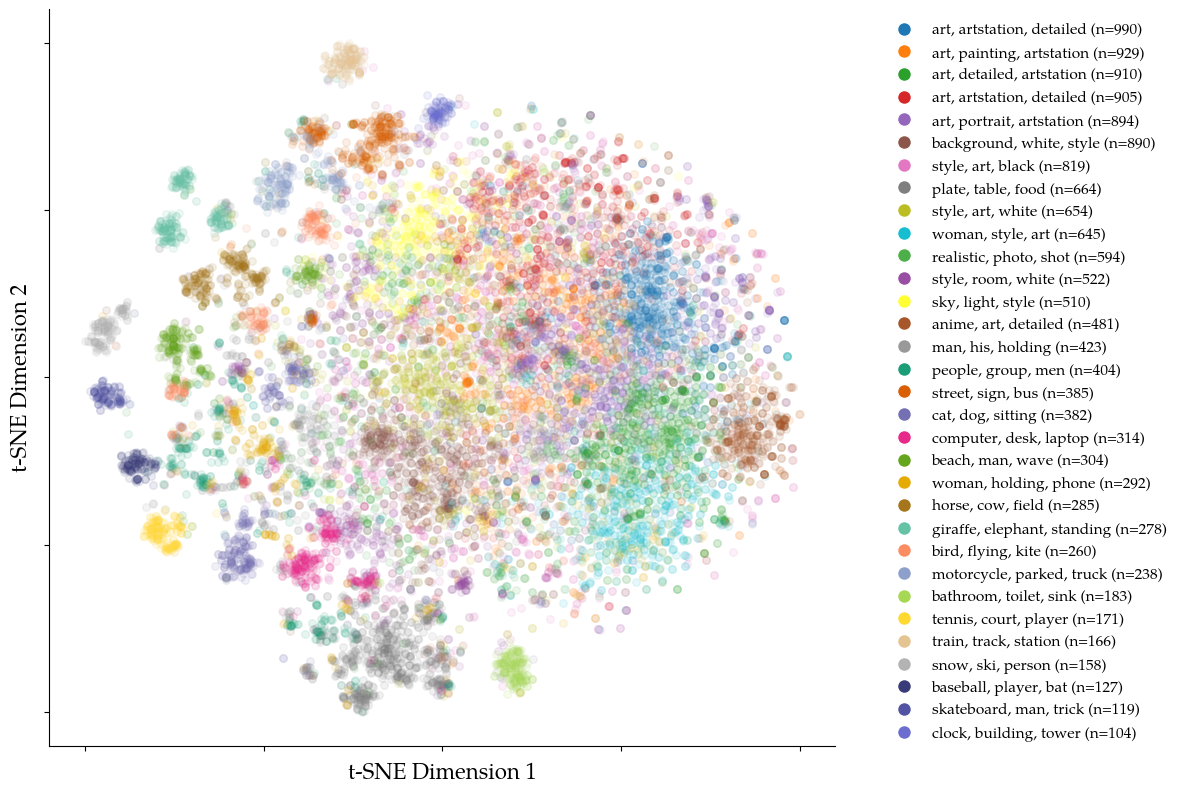

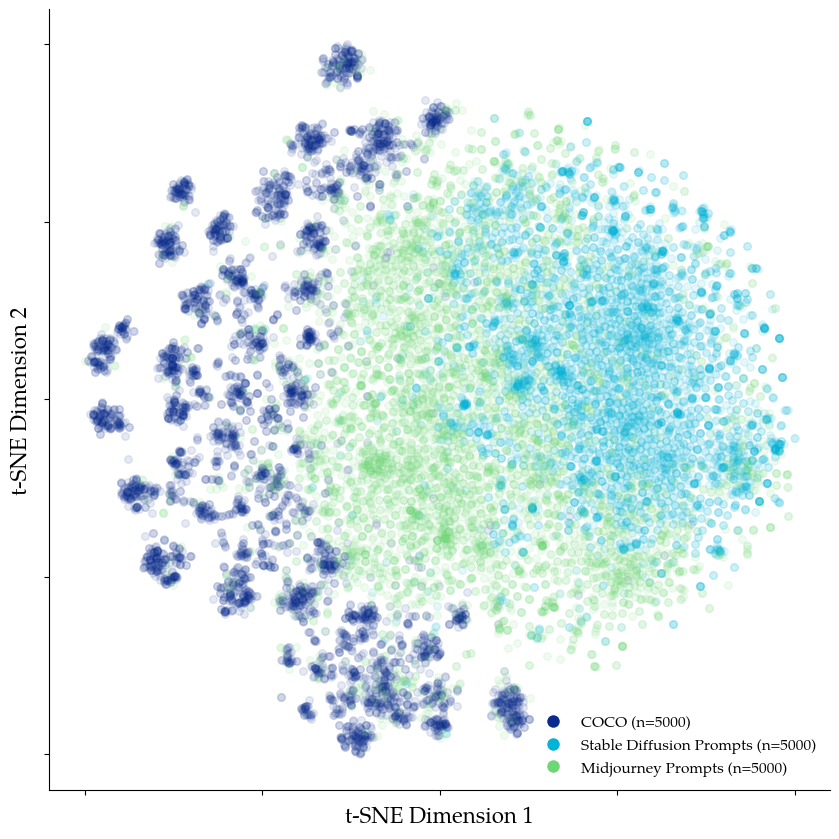

In [14]:
analyzer2 = PromptAnalyzer(load=False)
analyzer2.embeddings = embeddings
analyzer2.cluster_labels = labels
analyzer2.prompts_df = df

# Visualize clusters
xlim = (-7, 1.5)
ylim = (-2, 8)
top_n = 4
save_dir = 'dataset_comp'
save_path_clusters = os.path.join(save_dir, 'clusters_tsne.svg')
save_path_ds = os.path.join(save_dir, 'datasets_tsne.svg')
# analyzer2.visualize_clusters(coords, color_by='cluster', plot_legend = False, save_path = save_path_clusters, show_cluster_id = False)#, xlim=xlim, ylim=ylim)
# analyzer2.visualize_clusters(coords, color_by='dataset', plot_legend = False, save_path = save_path_ds)#, xlim=xlim, ylim=ylim)

save_path_clusters = os.path.join(save_dir, 'clusters_tsne_withLegend.pdf')
save_path_ds = os.path.join(save_dir, 'datasets_tsne_withLegend.pdf')
analyzer2.visualize_clusters(coords, color_by='cluster', plot_legend = True, figsize = (12, 8.5), save_path = save_path_clusters, show_cluster_id = False)#, xlim=xlim, ylim=ylim)
analyzer2.visualize_clusters(coords, color_by='dataset', plot_legend = True, figsize = (8.5, 8.5), save_path = save_path_ds)#, xlim=xlim, ylim=ylim)

# Create word clouds
# save_path = os.path.join(save_dir, 'wordclouds')
# top_words_list = create_dataset_wordclouds(datasets, save_path = save_path)


Top 10 words in Midjourney Prompts: style, white, background, black, realistic, art, color, light, dark, photo


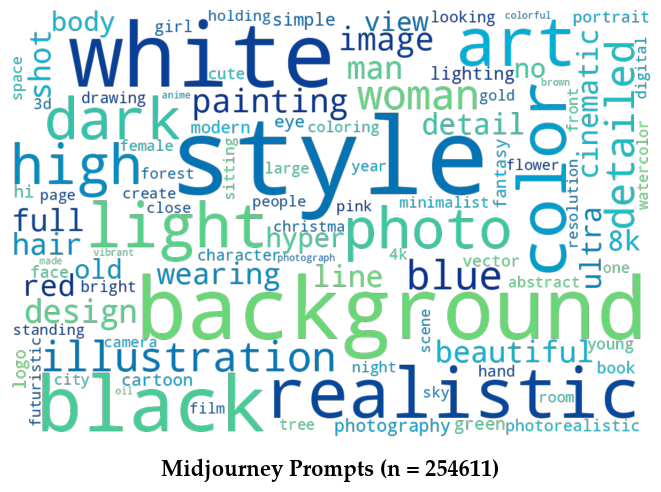

In [43]:
# Create word clouds
import matplotlib.colors
save_dir = 'dataset_comp'
save_path = os.path.join(save_dir, 'wordclouds')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#092B8C","#00B4D8","#6CD874"])

top_words_list = create_dataset_wordclouds(datasets, save_path = save_path, colormap = cmap)

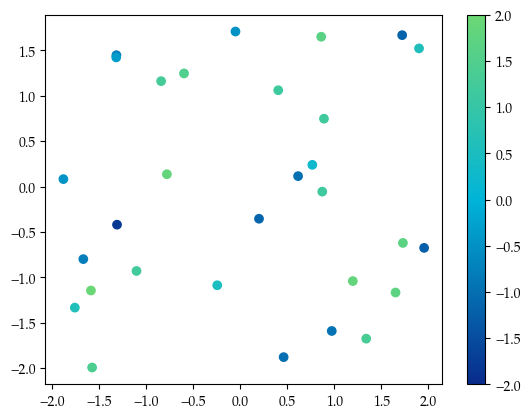

In [7]:
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#092B8C","#00B4D8","#6CD874"])

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()


Top 10 words in Cluster 0 (1395 prompts): banana, table, vase, sitting, flower, fruit, orange, next, bowl, white


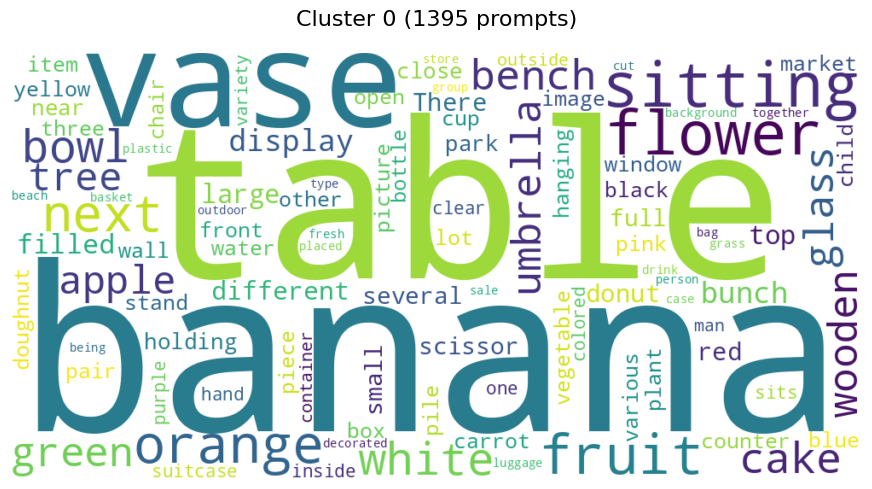

In [29]:
# Create cluster-specific word cloud
top_words_list_clusters = create_cluster_wordcloud(analyzer, cluster_id=0)


In [11]:
# Analyze cluster composition
analyze_cluster_composition(analyzer)

# Mean prompt lengths
mean_lengths_dataset = mean_prompt_length_per_dataset(analyzer)
mean_lengths_cluster = mean_prompt_length_per_cluster(analyzer)

Cluster Composition (counts):
dataset  COCO  Midjourney Prompts  Stable Diffusion Prompts  total
cluster                                                           
19          0                   7                      1130   1137
1           6                 280                       794   1080
10          0                 104                       905   1009
4           0                  15                       963    978
14         14                 872                        12    898
9           7                 642                       234    883
0           2                 561                       113    676
29          3                 471                       191    665
8           2                 472                       181    655
11         32                 562                        46    640
6         499                  34                         0    533
28        321                 172                         8    501
24          0                  7

In [9]:
from wordcloud import STOPWORDS

STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 